# 03. Concept Bottleneck Model (CBM)

This notebook implements a Concept Bottleneck Model.
**Architecture**: Input ($X$) $\to$ Backbone $\to$ Concepts ($C$) $\to$ Classifier $\to$ Output ($Y$).

**Note**: Since we do not have ground truth concept labels (like 'fracture', 'bleeding'), we will train this in a **Joint (End-to-End)** fashion. The 'Concept' layer will learn latent features that optimize the classification task. These features can be inspected later.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Config
DATA_ROOT = '../Data'
CLASSES = ['hemorrhagic', 'ischemic', 'tumor']
NUM_CONCEPTS = 10  # We will force the model to learn 10 concepts
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Define paths to source data for each class
DATA_SOURCES = {
    'hemorrhagic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Bleeding', 'PNG')
    ],
    'ischemic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Ischemia', 'PNG')
    ],
    'tumor': [
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'glioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'meningioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'pituitary')
    ]
}

Using device: mps


## 1. Data Loading
Using the robust BrainDataset loading logic.

In [2]:
class BrainDataset(Dataset):
    def __init__(self, data_sources, classes, transform=None):
        self.data_sources = data_sources
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self._prepare_data()
        
    def _prepare_data(self):
        for label_idx, class_name in enumerate(self.classes):
            if class_name not in self.data_sources:
                continue 
            sources = self.data_sources[class_name]
            for source_dir in sources:
                if not os.path.exists(source_dir):
                    continue
                valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')
                files = [f for f in os.listdir(source_dir) if f.lower().endswith(valid_exts)]
                for fname in files:
                    self.image_paths.append(os.path.join(source_dir, fname))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
        except:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
        if self.transform:
            img = self.transform(img)
        return img, label

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Use train transforms for both for simplicity given small dataset
val_transforms = train_transforms 

full_dataset = BrainDataset(DATA_SOURCES, CLASSES, transform=train_transforms)

# Debug: Print class distribution
from collections import Counter
label_counts = Counter(full_dataset.labels)
print("Loaded data distribution:")
for i, class_name in enumerate(CLASSES):
    print(f"  {class_name}: {label_counts[i]} images")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

Loaded data distribution:
  hemorrhagic: 1093 images
  ischemic: 1130 images
  tumor: 4117 images


## 2. CBM Architecture Definition

In [3]:
class CBM(nn.Module):
    def __init__(self, num_concepts, num_classes):
        super().__init__()
        # Backbone: X -> Concepts (Logits)
        self.backbone = models.resnet50(pretrained=True)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, num_concepts)
        
        # Head: Concepts (Probs) -> Y
        # We use sigmoid to ensure concepts are in [0,1]
        self.c2y = nn.Linear(num_concepts, num_classes)
        
    def forward(self, x):
        # Get concept logits from backbone
        c_logits = self.backbone(x)
        # Sigmoid to treat them as probabilities/activations
        c_probs = torch.sigmoid(c_logits)
        # Predict final class from concept probs
        y_logits = self.c2y(c_probs)
        return y_logits, c_probs

model = CBM(num_concepts=NUM_CONCEPTS, num_classes=len(CLASSES))
model = model.to(DEVICE)

/Users/hamzaelghonemy/Desktop/University/Senior/Neuroengineering/FinalProject/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hamzaelghonemy/Desktop/University/Senior/Neuroengineering/FinalProject/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## 3. Training Loop (End-to-End)

In [5]:
def train_cbm(model, criterion, optimizer, num_epochs=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, concepts = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # MPS fix: use .float() instead of .double()
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            if phase == 'val':
                os.makedirs('../models', exist_ok=True)
                torch.save(model.state_dict(), '../models/best_cbm.pth')
    return history

history = train_cbm(model, criterion, optimizer, num_epochs=EPOCHS)

Epoch 1/5
train Loss: 0.4777 Acc: 0.9217
val Loss: 0.3982 Acc: 0.9677
Epoch 2/5
train Loss: 0.3946 Acc: 0.9572
val Loss: 0.3432 Acc: 0.9811
Epoch 3/5
train Loss: 0.3506 Acc: 0.9643
val Loss: 0.3144 Acc: 0.9661
Epoch 4/5
train Loss: 0.3173 Acc: 0.9639
val Loss: 0.2873 Acc: 0.9685
Epoch 5/5
train Loss: 0.3039 Acc: 0.9472
val Loss: 0.2655 Acc: 0.9606


## 4. Concept Analysis
Visualize the learned concepts for a sample image.

In [6]:
# Load best model
model.load_state_dict(torch.load('../models/best_cbm.pth'))
model.eval()

inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(DEVICE)
outputs, concepts = model(inputs)

print("Concept Activations for first batch image:")
print(concepts[0].detach().cpu().numpy())
print(f"Predicted: {CLASSES[torch.max(outputs, 1)[1][0]]}, Actual: {CLASSES[labels[0]]}")

# Visualize the contribution of concepts to the decision
weights_c2y = model.c2y.weight.detach().cpu().numpy()
plt.figure(figsize=(10, 5))
plt.imshow(weights_c2y, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Concepts')
plt.ylabel('Classes')
plt.yticks(range(3), CLASSES)
plt.title('Concept-to-Class Weights')
plt.show()

Concept Activations for first batch image:
[9.9998629e-01 9.9998319e-01 3.2619889e-06 9.9998701e-01 2.8040555e-05
 9.9998558e-01 9.9997795e-01 2.2252461e-05 9.9997842e-01 1.4460208e-05]
Predicted: tumor, Actual: tumor


## 5. Detailed Evaluation
Classification Report, Confusion Matrix, and ROC Curves.

Classification Report:
              precision    recall  f1-score   support

 hemorrhagic       0.98      0.77      0.87       195
    ischemic       0.83      0.99      0.90       222
       tumor       1.00      1.00      1.00       851

    accuracy                           0.96      1268
   macro avg       0.94      0.92      0.92      1268
weighted avg       0.97      0.96      0.96      1268



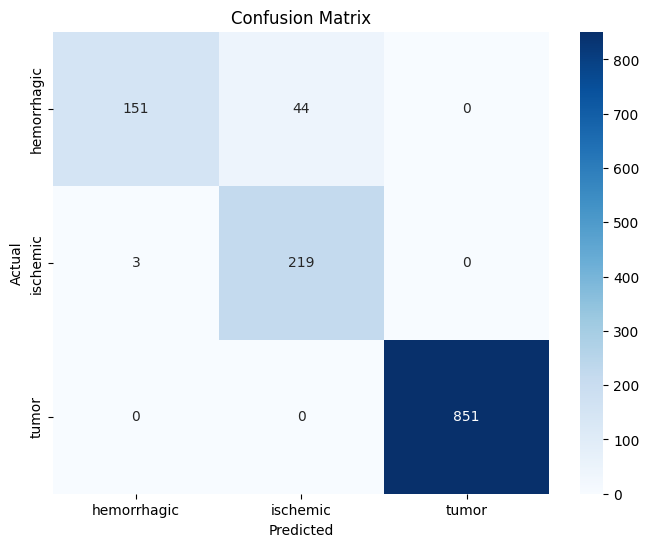

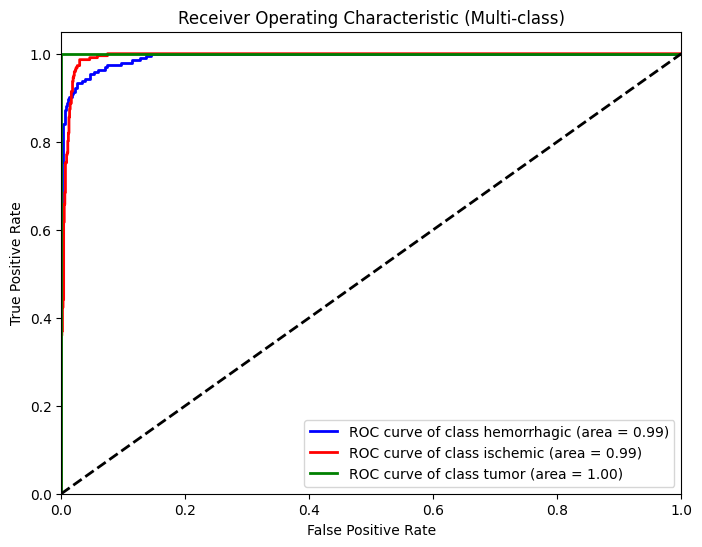

In [7]:
# Evaluation Metrics & Visualization
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. Collect Predictions
y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward pass (CBM returns logits, concepts)
        outputs, _ = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. ROC Curves (One-vs-Rest)
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(CLASSES[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()